##### Imports:

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
# deep learning

import numpy as np
# linear algebra

from scipy.integrate import solve_ivp
# dataset generaion solver

from torch.utils.data import DataLoader
from torch.utils.data import random_split
# data handling

import matplotlib.pyplot as plt
# plotting

from tqdm import tqdm
# progrees tracking

#### Datset Generation (Synthetic But Correct as per SciPy)

- Sample generation functions

In [13]:
def generate_ode_params(n_samples=1000):
    # generate coeffs a,b,c and y_0, for dy/dx = ax + by + c, initial condition y_0.

    np.random.seed(42)
    
    params = []
    for _ in range(n_samples):

        '''a = np.random.uniform(-2, 2)
        b = np.random.uniform(-2, 2)
        c = np.random.uniform(-2, 2)
        y0 = np.random.uniform(-2, 2)'''

        while True:
            a = np.random.uniform(-2, 2)
            b = np.random.uniform(-5, -0.5)  # Force exponential decay
            c = np.random.uniform(-2, 2)
            y0 = np.random.uniform(-10, 10)
            # Solve and check stability
            _, y = solve_ode(a, b, c, y0)
            if np.max(np.abs(y)) < 1000:  # Reject explosive solutions
                break

        # why (-2,2): numerical stability
        # otherwise, solutions to the diff eqns may vary wildly which will cause
        # problems in computing MSE loss.

        # eg. if params: (a=0, b=10, c=0, y_0=1) dy/dx = 0x + 10y + 0
        # solution: y = e^(10x), so as x -> infty, major changes

        # LIMITATION: less generalizable to larger magnitude solutions
        # neural net may not learn everything

        params.append((a, b, c, y0))
    return params


def solve_ode(a, b, c, y0, x_span=(0, 5), num_points=50):

    # solve dy/dx = ax + by + c with initial condition y_0 by enumeration

    # essentially, numerically solving and "plotting" the continuous curve at 50 points, 
    # in the interval (0,5)

    def ode_func(x, y):
        return a*x + b*y + c

    x_eval = np.linspace(x_span[0], x_span[1], num_points)
    # 50 points of a curve between 0 to 5

    sol = solve_ivp(ode_func, x_span, [y0], t_eval=x_eval, method='RK45')

    # sol.y[0] == solution for y at x_eval
    return x_eval, sol.y[0]


- Verifying with an online solver for some random cases.

In [14]:
synthetic_dataset_param_tuples = generate_ode_params(3)

for ai, bi, ci, y0i in synthetic_dataset_param_tuples:
    (x,y) = solve_ode(ai, bi, ci, y0i)
    print(f"Params: ai = {ai}, bi = {bi}, ci = {ci}, y0i = {y0i}")
    print(f"y(x) at x = 0 is {y[0]}, at x = 5 is {y[-1]}")
    print()


Params: ai = -0.50183952461055, bi = -0.7217856211553775, ci = 0.9279757672456204, y0i = 1.973169683940732
y(x) at x = 0 is 1.973169683940732, at x = 5 is -1.2350324996358422

Params: ai = -1.375925438230254, bi = -4.298024658487088, ci = -1.7676655513272022, y0i = 7.323522915498703
y(x) at x = 0 is 7.323522915498703, at x = 5 is -1.936500288258907

Params: ai = 0.4044600469728352, bi = -1.8136733999177954, ci = -1.9176620228167902, y0i = 9.398197043239886
y(x) at x = 0 is 9.398197043239886, at x = 5 is -0.06399014355242708



In [15]:
class ODEDataset_Linear(torch.utils.data.Dataset):
    def __init__(self, n_samples=1000, x_span=(0, 5), num_points=50):
        self.x_eval = np.linspace(x_span[0], x_span[1], num_points)
        self.samples = []
        
        params_list = generate_ode_params(n_samples)
        for a, b, c, y0 in params_list:
            _, y = solve_ode(a, b, c, y0, x_span, num_points)
            
            # store as (params, solution)
            self.samples.append( (np.array([a, b, c, y0], dtype=np.float32), y.astype(np.float32)) )
            # store the value of y for x = 5

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        params, y = self.samples[idx]
        return torch.from_numpy(params), torch.from_numpy(y)

In [16]:
full_dataset = ODEDataset_Linear(n_samples=1000)

# Split into 600 train + 100 validation + 300 Test (60/10/30 split)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [0.6, 0.1, 0.3], generator = torch.Generator().manual_seed(42))

# Create DataLoaders (batch size 32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32)

#### Model Architecture:

##### Hypernetwork
Trains the weights for the solution network (up next).

In [17]:
class HyperNet(nn.Module):
    def __init__(self, param_dim=4, hidden_dim=64, output_dim=25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(param_dim, hidden_dim),
            # hidden layer, 64 dim
            nn.ReLU(),
            # V

            nn.Linear(hidden_dim, hidden_dim),
            # hidden layer, 64 dim
            nn.ReLU(),
            # V

            nn.Linear(hidden_dim, output_dim)
            # V (taken into SolnNet)
        )
    
    def forward(self, ode_params):
        return self.net(ode_params)

##### Solution Network
Given trained weights from Hypernetwork, makes a predection with a single layer neural network.

In [18]:
class SolutionNet(nn.Module):
    def forward(self, x, meta_params):

        # pytorch tensor operations-

        # meta_params - tensor of shape [batch_size, 25]
        

        # eg. hidden layer weight
        w1 = meta_params[:, :16].view(-1, 4, 4)
        # 1.  meta_params[:, (<- slice which takes from each batch,)  :16] <- 16 elements
        # 2. reshapes to tensor of shape [batch_size, 4, 4] 

        # eg. hidden layer bias
        b1 = meta_params[:, 16:20].view(-1, 4) 
        # 1.  meta_params[:, (<- slice which takes from each batch,)  16:20] <- elements 16 through 20-1 = 19
        # 2. reshapes to tensor of shape [batch_size, 4]

        # similarly,
        w2 = meta_params[:, 20:24].view(-1, 4, 1) # output layer weights
    
        b2 = meta_params[:, 24:25].view(-1, 1)    # output layer bias
    
        x = x.unsqueeze(-1).expand(-1, -1, 4)
        # Reshape: [batch, num_points] -> [batch, num_points, 1]

        h = torch.relu(torch.matmul(x, w1) + b1.unsqueeze(1))
        # b1.unsqueeze(1): [batch, 1, 4] 4 == num of hidden layers 

        # Compute (x @ w1) + b1,
        ## x: [batch, num_points, 1]
        # w1: [batch, 1, 4]
        # o/p: [batch, num_points, 4]

        return torch.matmul(h, w2) + b2.unsqueeze(1)
        # b2.unsqueeze(1): [batch, num_points]

        # Compute:(h @ w2) + b2
        # h: [batch, num_points, 4]
        # w2: [batch, 4, 1]
        # o/p: [batch, num_points, 1]


##### Training: MSE + Backprop

- Initialise Networks

In [19]:
hyper_param_net = HyperNet(param_dim=4, hidden_dim=64, output_dim=25)
solution_net = SolutionNet()

- Connect to Device

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyper_param_net.to(device)
solution_net.to(device)

torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3050 Laptop GPU'

- Set up base Hyperparameters

In [21]:
optimizer = torch.optim.Adam(hyper_param_net.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

- Training Loop:

In [22]:
num_epochs = 500
train_losses = []

for epoch in tqdm(range(num_epochs)):
    hyper_param_net.train()
    total_loss = 0.0

    for ode_params, y_true in train_loader:
        ode_params = ode_params.to(device)  # [batch, 4]
        y_true = y_true.to(device)          # [batch, num_points]

        # forward pass through hyper parameter network
        meta_params = hyper_param_net(ode_params)  # [batch, 25]

        # prepare x-points for each sample in the batch
        batch_size, num_points = y_true.shape
        x_points = torch.linspace(0, 5, num_points, device=device).repeat(batch_size, 1)  # [batch, num_points]

        # Forward pass through solution network
        y_pred = solution_net(x_points, meta_params).squeeze(-1)  # [batch, num_points]

        # Compute loss
        loss = loss_fn(y_pred, y_true)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

    avg_loss = total_loss / len(train_loader.dataset)

    #print(avg_loss)
    train_losses.append(avg_loss)

100%|██████████| 500/500 [00:42<00:00, 11.72it/s]


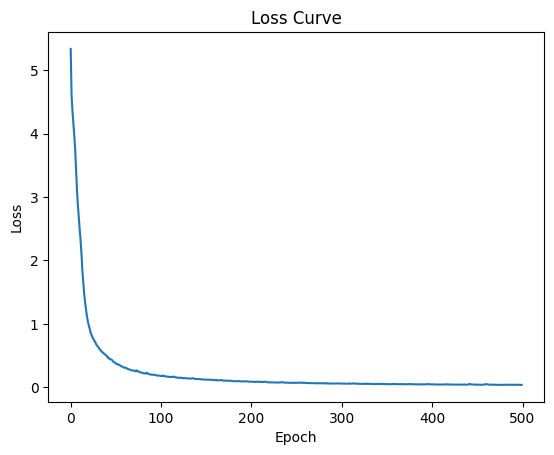

In [23]:
plt.plot(train_losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

##### Testing

In [24]:
# Save the trained model
torch.save({
    'hyper_param_net': hyper_param_net.state_dict(),
    'solution_net': solution_net.state_dict(),
}, 'meta_ode_solver.pt')

# evaluate model performance
hyper_param_net.eval()
test_loss = 0.0
with torch.no_grad():
    for ode_params, y_true in test_loader:
        ode_params = ode_params.to(device)
        y_true = y_true.to(device)
        
        meta_params = hyper_param_net(ode_params)
        x_points = torch.linspace(0, 5, y_true.shape[1], device=device).repeat(ode_params.shape[0], 1)
        y_pred = solution_net(x_points, meta_params).squeeze(-1)
        
        test_loss += loss_fn(y_pred, y_true).item() * ode_params.size(0)

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.0687


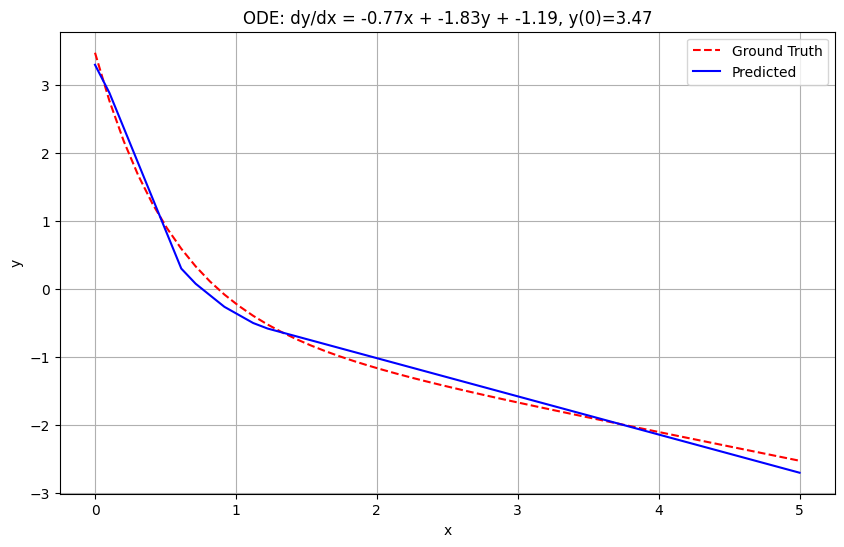

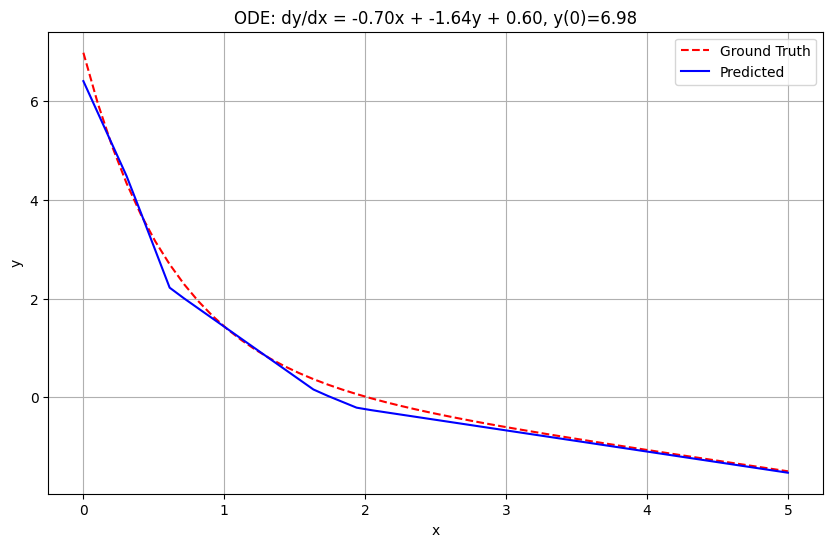

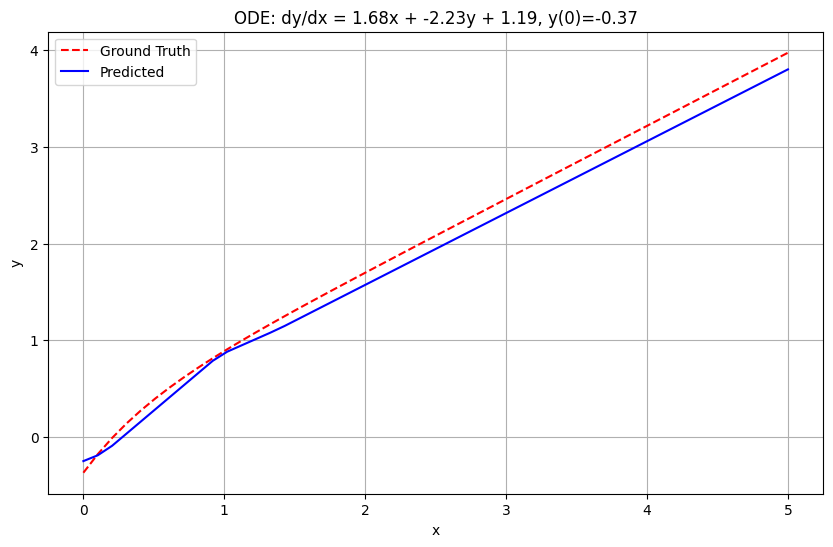

In [25]:
import matplotlib.pyplot as plt

def plot_solutions(ode_params, y_true, y_pred, idx=0):
    """Plot true vs predicted solutions for a single ODE"""
    a, b, c, y0 = ode_params[idx].cpu().numpy()
    x = np.linspace(0, 5, y_true.shape[1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_true[idx].cpu().numpy(), 'r--', label='Ground Truth')
    plt.plot(x, y_pred[idx].cpu().numpy(), 'b-', label='Predicted')
    plt.title(f"ODE: dy/dx = {a:.2f}x + {b:.2f}y + {c:.2f}, y(0)={y0:.2f}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize a few examples
with torch.no_grad():
    for ode_params, y_true in test_loader:
        ode_params = ode_params.to(device)
        y_true = y_true.to(device)
        
        meta_params = hyper_param_net(ode_params)
        x_points = torch.linspace(0, 5, y_true.shape[1], device=device).repeat(ode_params.shape[0], 1)
        y_pred = solution_net(x_points, meta_params).squeeze(-1)
        
        # Plot first 3 examples
        for i in range(min(3, ode_params.size(0))):
            plot_solutions(ode_params, y_true, y_pred, idx=i)
        break


In [26]:
import time

def benchmark_performance(test_loader, n_runs=10):
    """Compare speed of META-ODE vs numerical solver"""
    # Timing META-ODE
    meta_times = []
    for _ in range(n_runs):
        start = time.time()
        with torch.no_grad():
            for ode_params, _ in test_loader:
                ode_params = ode_params.to(device)
                meta_params = hyper_param_net(ode_params)
                x_points = torch.linspace(0, 5, 50, device=device).repeat(ode_params.shape[0], 1)
                y_pred = solution_net(x_points, meta_params).squeeze(-1)
        meta_times.append(time.time() - start)
    
    # Timing numerical solver
    numeric_times = []
    for _ in range(n_runs):
        start = time.time()
        for ode_params, _ in test_loader:
            params_np = ode_params.numpy()
            for i in range(params_np.shape[0]):
                a, b, c, y0 = params_np[i]
                def ode_func(x, y):
                    return a * x + b * y + c
                solve_ivp(ode_func, (0, 5), [y0], t_eval=np.linspace(0, 5, 50))
        numeric_times.append(time.time() - start)
    
    print(f"META-ODE average time: {np.mean(meta_times):.4f}s")
    print(f"Numerical solver average time: {np.mean(numeric_times):.4f}s")
    print(f"Speedup: {np.mean(numeric_times)/np.mean(meta_times):.2f}x")

benchmark_performance(test_loader)


META-ODE average time: 0.0057s
Numerical solver average time: 0.1769s
Speedup: 31.09x
